# EvalML Solution

<p style="margin:30px">
    <img width=50% src="https://evalml-web-images.s3.amazonaws.com/evalml_horizontal.svg" alt="Featuretools" />
</p>

In this notebook, we'll use EvalML to predict future daily average temperatures using historical temperature data. This is a time series machine learning problem, which requires special considerations during preprocessing, feature engineering, and model building, and EvalML's Time Series Regression problem type will handle all of this for us.

To see a simplified baseline solution, check out the [Baseline Solution](Daily%20Temperature%202%20-%20Featuretools%20Solution.ipynb).

## Configure Problem

In [1]:
import warnings
warnings.filterwarnings('ignore')
import utils
import evalml
from IPython.display import Image

In [2]:
filepath = "dataset/DailyDelhiClimate.csv"

time_index = "date"
target_col = 'meantemp'

df = utils.read_data(filepath, time_index, target_col)
df.head(10)

,date,meantemp
0,2013-01-01,10.000000
1,2013-01-02,7.400000
2,2013-01-03,7.166667
3,2013-01-04,8.666667
4,2013-01-05,6.000000
5,2013-01-06,7.000000
6,2013-01-07,7.000000
7,2013-01-08,8.857143
8,2013-01-09,14.000000
9,2013-01-10,11.000000


EvalML defines the problem configuration with several concepts that are more fully described in the [EvalML time series user guide](https://evalml.alteryx.com/en/stable/user_guide/timeseries.html#Running-AutoMLSearch). 

Our problem can be described as trying to predict the mean temperature 3 to 8 days out using temperature data from 20 days prior. With the concepts above in-hand, we can define our parameters as follows:

In [3]:
gap = 3
max_delay = 20
forecast_horizon = 5

## Data Splitting

Here, we can use EvalML's time series data splitting capabilities, which will leave us with data that has its time index in tact.

In [4]:
X = df.copy()
y = X.pop(target_col)

X_train, X_test, y_train, y_test = evalml.preprocessing.split_data(X, y,
                                                                   problem_type='time series regression',
                                                                   test_size=.3,
                                                                  problem_configuration={"gap": gap, 
                                                                                         "max_delay": max_delay,
                                                                                         "forecast_horizon": forecast_horizon,
                                                                                         "time_index": time_index},)

X_train.head()

,date
0,2013-01-01
1,2013-01-02
2,2013-01-03
3,2013-01-04
4,2013-01-05


## Model Building 
Now we can perform AutoMLSearch, which will provide us with six pipelines, one of which is the same as the one we used in our baseline notebook! 

In [5]:
automl = evalml.AutoMLSearch(X_train, y_train, problem_type="time series regression",
                             max_batches=1,
                             problem_configuration={"gap": gap, 
                                                    "max_delay": max_delay,
                                                    "forecast_horizon": forecast_horizon, 
                                                    "time_index": time_index},
                             allowed_model_families=["xgboost", "random_forest", "linear_model", "extra_trees",
                                                     "decision_tree"],
                             objective='MedianAE'
                             )
# Fit and predict on the model
automl.search()

Below are the summaries of the six pipelines that were run.

In [6]:
automl.rankings

,id,pipeline_name,search_order,mean_cv_score,standard_deviation_cv_score,validation_score,percent_better_than_baseline,high_variance_cv,parameters
0,1,Elastic Net Regressor w/ Imputer + Time Series...,1,1.785836,0.264819,1.785836,4.452079,False,{'Imputer': {'categorical_impute_strategy': 'm...
1,5,Extra Trees Regressor w/ Imputer + Time Series...,5,1.828006,0.506451,1.828006,2.195866,False,{'Imputer': {'categorical_impute_strategy': 'm...
2,0,Time Series Baseline Regression Pipeline,0,1.869048,0.220399,1.869048,0.000000,False,{'Time Series Featurizer': {'time_index': 'dat...
3,3,Random Forest Regressor w/ Imputer + Time Seri...,3,1.874123,0.493700,1.874123,-0.271564,False,{'Imputer': {'categorical_impute_strategy': 'm...
4,4,Decision Tree Regressor w/ Imputer + Time Seri...,4,1.961404,0.615493,1.961404,-4.941346,False,{'Imputer': {'categorical_impute_strategy': 'm...
5,2,XGBoost Regressor w/ Imputer + Time Series Fea...,2,2.047577,0.367982,2.047577,-9.551871,False,{'Imputer': {'categorical_impute_strategy': 'm...


The `mean_cv_score` shown here is the median absolute error for predictions calculated using subsets of the training data. To see how these models perform on unseen data, we'll have to score the test data.

We'll investigate further into pipeline #3, since it's the Random Forest Regressor, which is what we used in the other demo notebooks.

In [7]:
pipeline =  automl.get_pipeline(3)
pipeline.fit(X_train, y_train)
random_forest_evalml_score = pipeline.score(X_test, y_test, ['MedianAE'], X_train, y_train)['MedianAE']
random_forest_evalml_score

1.6967243283642581

Our model creatued using EvalML is performing slightly better than our Featuretools run! We can also inspect the feature importances. The top four features are in slightly different orders, but they are the same as our Featuretools run.

In [8]:
pipeline.feature_importance

,feature,importance
0,target_delay_8,0.468741
1,target_rolling_mean,0.397222
2,date_month,0.056244
3,target_delay_9,0.036112
4,target_delay_17,0.008262
5,target_delay_15,0.005567
6,target_delay_13,0.005108
7,target_delay_16,0.004215
8,target_delay_11,0.004214
9,target_delay_12,0.004002


These feature importances are remarkably similar to those produced in the [Featuretools Solution](Daily%20Temperature%202%20-%20Featuretools%20Solution.ipynb).

We'll also take a look at the baseline pipeline and see how it compares to the baseline notebook's model.

In [9]:
baseline = automl.get_pipeline(0)
baseline.fit(X_train, y_train)
baseline_evalml_score = baseline.score(X_test, y_test, ['MedianAE'], X_train, y_train)['MedianAE']
baseline_evalml_score

2.25

Indeed, our baseline score from EvalML is very similar to the one we calculated ourselves, and below we can see the feature importance of 1 for the single delayed feature. The other two features with zero importance are side effects of the AutoMLSearch process and were not included in the model itself.

In [10]:
baseline.feature_importance

,feature,importance
0,target_delay_8,1
1,date,0
2,target_rolling_mean,0


## Visualizing Predictions
Beyond our use of median absolute error for evaluating models, we can also use our eyes! Here are two graphs of the predictions.

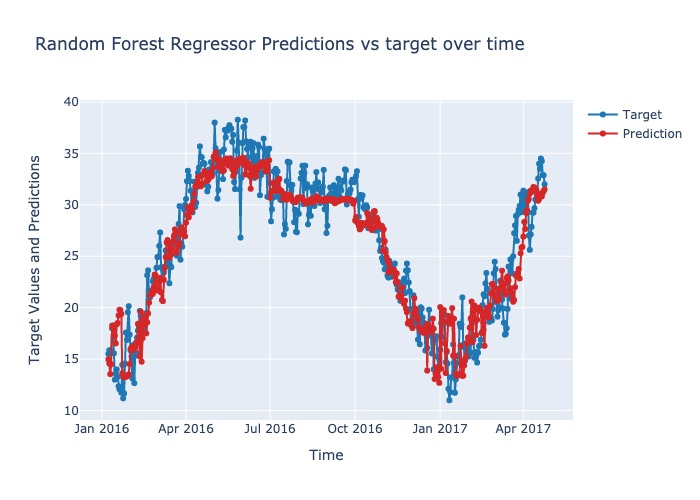

In [11]:
fig = evalml.model_understanding.graph_prediction_vs_actual_over_time(pipeline, 
                                                                      X_test, 
                                                                      y_test, 
                                                                      X_train, 
                                                                      y_train, 
                                                                      dates=X_test['date'])
fig.update_layout(title="Random Forest Regressor Predictions vs target over time")
fig.write_image("figures/random_forest.jpeg")
Image(filename="figures/random_forest.jpeg")

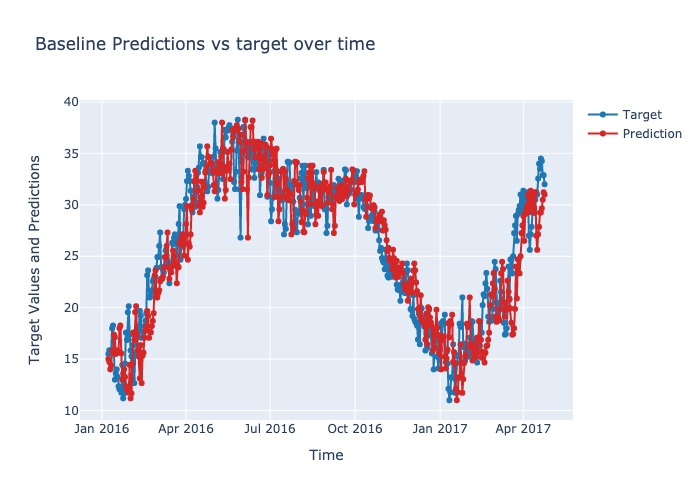

In [12]:
fig = evalml.model_understanding.graph_prediction_vs_actual_over_time(baseline, 
                                                                      X_test, 
                                                                      y_test, 
                                                                      X_train, 
                                                                      y_train, 
                                                                      dates=X_test['date'])
fig.update_layout(title="Baseline Predictions vs target over time")
fig.write_image("figures/baseline.jpeg")
Image(filename="figures/baseline.jpeg")

Notice how the prediction for the baseline run is essentially a shifted version of the target data. This makes sense, as the only feature used was a delayed version of the target data. Using more features, such as the rolling mean, we get predictions that are better, because they follow the rolling mean more tightly.

## Next Steps

This notebook, which uses only EvalML functions and classes, achieves very similar results to the manual Featuretools run from the second notebook, and it performs a lot of the same steps to perform model understanding. This highlights the power and simplicity of using EvalML. And just like Featuretools, there are ways we can try to improve our results within EvalML

One way to do that would be to use one of the other time series regressors that EvalML makes use of: the [ARIMA Regressor](https://evalml.alteryx.com/en/stable/autoapi/evalml/pipelines/components/estimators/regressors/arima_regressor/index.html?highlight=arima) and the [Prophet Regressor](https://evalml.alteryx.com/en/stable/autoapi/evalml/pipelines/components/estimators/regressors/prophet_regressor/index.html?highlight=prophet).

EvalML and Featuretools' support for time series forecasting is ongoing, and more information about the time series capabilities can be found here:

- https://evalml.alteryx.com/en/stable/user_guide/timeseries.html
- insert link to feature tools time series